# Import libraries

You can downlooad the dataset from this link : https://www.kaggle.com/datasets/sharansmenon/aquarium-dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# remove warnings 
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes # draw bounding boxes

print(torch.__version__)
print(torchvision.__version__)

1.12.0
0.13.0


In [4]:
# !pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' --> run from conda
from pycocotools.coco import COCO # processing about annotations 

# Define transformation properties

In [5]:
# Define our transforms
from albumentations.pytorch import ToTensorV2

def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), 
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
        
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
        
    return transform

# Define dataset class

In [6]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [7]:
# Define the train dataset path
dataset_path = "./Aquarium Combined/"

#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [22]:
coco.loadAnns(coco.getAnnIds(0)) # It takes the image id , not bounding box ids

[{'id': 0,
  'image_id': 0,
  'category_id': 2,
  'bbox': [0, 752, 176, 243],
  'area': 42768,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 0,
  'category_id': 2,
  'bbox': [126, 738, 431, 184],
  'area': 79304,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 0,
  'category_id': 2,
  'bbox': [10, 845, 202, 133],
  'area': 26866,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 0,
  'category_id': 2,
  'bbox': [490, 486, 208, 123],
  'area': 25584,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 4,
  'image_id': 0,
  'category_id': 2,
  'bbox': [665, 265, 102, 55],
  'area': 5610,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 5,
  'image_id': 0,
  'category_id': 2,
  'bbox': [541, 933, 226, 90],
  'area': 20340,
  'segmentation': [],
  'iscrowd': 0}]

In [27]:
coco.loadImgs(0)[0]['file_name']

'IMG_2489_jpeg_jpg.rf.ffb357957a29cdef43f3fdfb2a13c417.jpg'

In [28]:
# Get class names
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [29]:
# Load the dataset
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [32]:
len(train_dataset.ids)

447

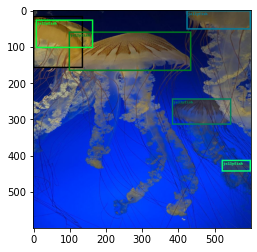

In [30]:
# Lets view a sample
sample = train_dataset[0]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [46]:
sample

(tensor([[[0.8353, 0.7765, 0.7294,  ..., 0.4941, 0.4824, 0.4745],
          [0.8824, 0.8431, 0.8039,  ..., 0.4902, 0.4941, 0.4980],
          [0.7843, 0.7765, 0.7647,  ..., 0.4863, 0.4902, 0.4941],
          ...,
          [0.0706, 0.0745, 0.0784,  ..., 0.1020, 0.1020, 0.1020],
          [0.0745, 0.0745, 0.0784,  ..., 0.0941, 0.0941, 0.0902],
          [0.0745, 0.0784, 0.0824,  ..., 0.0980, 0.0941, 0.0902]],
 
         [[0.7294, 0.6706, 0.6235,  ..., 0.4471, 0.4353, 0.4275],
          [0.7765, 0.7373, 0.6980,  ..., 0.4431, 0.4471, 0.4510],
          [0.6863, 0.6784, 0.6667,  ..., 0.4392, 0.4431, 0.4471],
          ...,
          [0.1569, 0.1608, 0.1647,  ..., 0.2471, 0.2471, 0.2471],
          [0.1608, 0.1608, 0.1686,  ..., 0.2392, 0.2392, 0.2353],
          [0.1608, 0.1647, 0.1686,  ..., 0.2431, 0.2392, 0.2353]],
 
         [[0.6863, 0.6275, 0.5804,  ..., 0.4863, 0.4745, 0.4667],
          [0.7333, 0.6941, 0.6549,  ..., 0.4824, 0.4863, 0.4902],
          [0.6471, 0.6392, 0.6275,  ...,

# Define the datasets

In [33]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))
val_dataset = AquariumDetection(root=dataset_path, split="valid", transforms=get_transforms(False))
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [34]:
len(train_dataset), len(val_dataset), len(test_dataset)

(447, 127, 63)

# Call the pre-trained model(Mobilenet-v3)

In [35]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\raufc/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

# Define dataset loaders

In [36]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)

# Check model is working or not

In [55]:
for t in targets:
    for k,v in t.items():
        print(k)
        print(v)
        print("-"*25)

boxes
tensor([[219.5312,  99.0234, 528.1250, 364.4531],
        [397.6562, 448.8281, 533.5938, 541.4062],
        [359.3750, 570.1172, 454.6875, 599.4141]])
-------------------------
labels
tensor([7, 7, 1])
-------------------------
image_id
tensor([146, 146, 146])
-------------------------
area
tensor([81909.9453, 12584.8389,  2792.3584])
-------------------------
iscrowd
tensor([0, 0, 0])
-------------------------
boxes
tensor([[172.9167, 283.0078, 242.7083, 322.2656],
        [398.9583, 455.2734, 502.0833, 491.0156],
        [488.5417, 356.8359, 565.6250, 391.9922],
        [563.5417, 143.5547, 598.9583, 168.7500],
        [  0.0000, 440.6250,  20.8333, 462.3047],
        [570.8333, 306.4453, 598.9583, 328.7109],
        [463.5417, 454.1016, 498.9583, 474.0234],
        [219.7917,  66.2109, 275.0000,  82.6172],
        [178.1250, 479.2969, 222.9167, 499.2188]])
-------------------------
labels
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2])
-------------------------
image_id
tensor([441, 441, 

In [56]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

# Set device to GPU
device = torch.device("cuda") # use GPU to train
model = model.to(device)


# Set optimizer

In [60]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [195]:
a,b = next(iter(train_loader))
a[3].shape

torch.Size([3, 600, 600])

# Training the model

In [61]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [62]:
# Train the model for 10 epoch

num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:59<00:00,  1.88it/s]


Epoch 0, lr: 0.010000, loss: 0.990285, loss_classifier: 0.477946, loss_box: 0.388845, loss_rpn_box: 0.034042, loss_object: 0.089451


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:55<00:00,  2.03it/s]


Epoch 1, lr: 0.010000, loss: 0.812535, loss_classifier: 0.375542, loss_box: 0.346956, loss_rpn_box: 0.028357, loss_object: 0.061680


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:54<00:00,  2.07it/s]


Epoch 2, lr: 0.010000, loss: 0.730969, loss_classifier: 0.306946, loss_box: 0.350727, loss_rpn_box: 0.026319, loss_object: 0.046976


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:53<00:00,  2.11it/s]


Epoch 3, lr: 0.010000, loss: 0.712232, loss_classifier: 0.289095, loss_box: 0.357799, loss_rpn_box: 0.025378, loss_object: 0.039960


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:52<00:00,  2.13it/s]


Epoch 4, lr: 0.010000, loss: 0.658570, loss_classifier: 0.255123, loss_box: 0.343813, loss_rpn_box: 0.023392, loss_object: 0.036241


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:51<00:00,  2.17it/s]


Epoch 5, lr: 0.010000, loss: 0.665851, loss_classifier: 0.256038, loss_box: 0.356731, loss_rpn_box: 0.022779, loss_object: 0.030303


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:51<00:00,  2.17it/s]


Epoch 6, lr: 0.010000, loss: 0.646921, loss_classifier: 0.244768, loss_box: 0.351956, loss_rpn_box: 0.021995, loss_object: 0.028203


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:51<00:00,  2.19it/s]


Epoch 7, lr: 0.010000, loss: 0.624501, loss_classifier: 0.230786, loss_box: 0.343808, loss_rpn_box: 0.021354, loss_object: 0.028553


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:50<00:00,  2.22it/s]


Epoch 8, lr: 0.010000, loss: 0.629094, loss_classifier: 0.233264, loss_box: 0.347349, loss_rpn_box: 0.021132, loss_object: 0.027349


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:50<00:00,  2.22it/s]

Epoch 9, lr: 0.010000, loss: 0.621813, loss_classifier: 0.225437, loss_box: 0.350558, loss_rpn_box: 0.021148, loss_object: 0.024670


# Inference mode with test image

In [63]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [130]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [131]:
img.shape

torch.Size([3, 600, 600])

In [132]:
pred

{'boxes': tensor([[9.9028e+01, 3.0850e+02, 2.1060e+02, 3.4807e+02],
         [1.2993e+02, 1.3464e+02, 2.8299e+02, 1.8358e+02],
         [4.3484e+02, 3.2470e+01, 5.0630e+02, 5.6614e+01],
         [0.0000e+00, 6.3591e+01, 5.9413e+01, 1.0631e+02],
         [1.8339e+02, 0.0000e+00, 2.6809e+02, 2.1716e+01],
         [3.5532e+02, 5.9185e+01, 4.0698e+02, 7.9059e+01],
         [4.9709e+02, 2.5594e-01, 5.5773e+02, 1.7555e+01],
         [3.9233e+02, 6.1613e+01, 4.6650e+02, 8.3760e+01],
         [1.8432e+02, 0.0000e+00, 2.5974e+02, 7.1825e+00],
         [3.6920e+02, 2.5229e+02, 4.5850e+02, 2.8835e+02],
         [3.7487e+02, 2.5102e+02, 4.5307e+02, 2.8586e+02],
         [3.5779e+02, 5.6849e+01, 3.9802e+02, 6.8436e+01],
         [4.9518e+02, 1.3530e+01, 5.3583e+02, 2.6993e+01],
         [2.6759e+02, 1.7169e+02, 3.1988e+02, 1.9152e+02],
         [2.9750e+02, 0.0000e+00, 3.4465e+02, 1.3069e+01],
         [2.9428e+02, 0.0000e+00, 3.4886e+02, 6.7519e+00],
         [1.8962e-01, 6.6705e+01, 5.4923e+01, 1

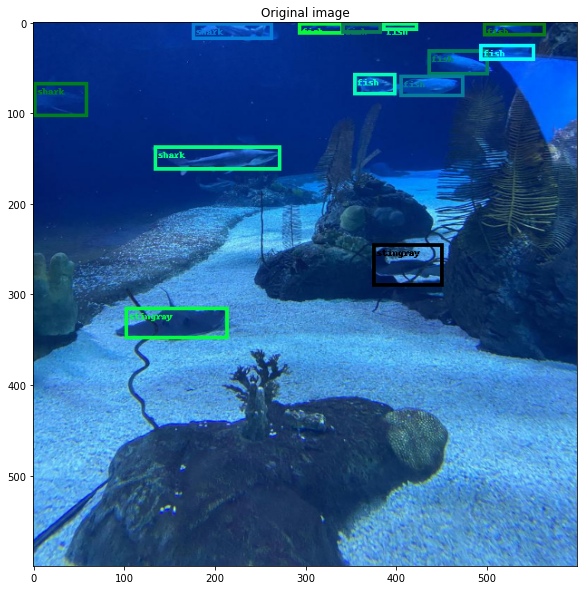

In [133]:
# Lets view a sample
sample = test_dataset[5]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)

fig = plt.figure(figsize=(14, 10))
plt.title('Original image')
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0));

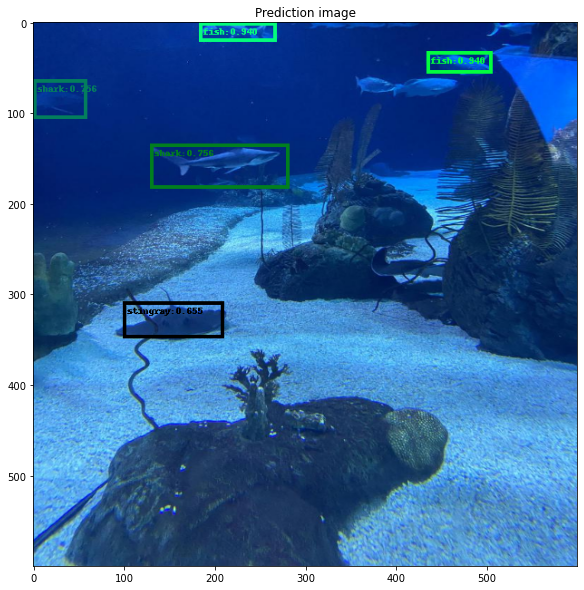

In [135]:
scores=["{:.3f}".format(score.item()) for score in pred['scores']]

fig = plt.figure(figsize=(14, 10))
plt.title('Prediction image')
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [str(classes[i])+str(":")+str(scores[i]) for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0));


In [136]:
pred_img = draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [str(classes[i])+str(":")+str(scores[i]) for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0)

In [145]:
pred['boxes'][pred['scores'] > 0.8]

tensor([ 99.0275, 308.5016, 210.5973, 348.0726], device='cuda:0')

In [155]:
pred_img.shape

torch.Size([600, 600, 3])

In [107]:
print(pred_img.shape)

pred_img=np.array(pred_img)
pred_img=cv2.cvtColor(pred_img,cv2.COLOR_BGR2RGB)
print(pred_img.shape)

cv2.imwrite("predicted_img.jpg",pred_img)

print('Predicted image was saved!!')

(600, 600, 3)
(600, 600, 3)
Predicted image was saved!!


In [129]:
pred_img.shape

(600, 600, 3)

In [68]:
a=[str(classes[i])+str(":")+str(scores[i]) for i in pred['labels'][pred['scores'] > 0.8].tolist()]
a

['stingray', 'shark', 'fish', 'shark', 'fish']

In [70]:
for i in pred['labels'][pred['scores'] > 0.8].tolist():
    print(i)

7
5
1
5
1


In [71]:
pred['labels']

tensor([7, 5, 1, 5, 1, 1, 1, 1, 1, 5, 7, 1, 1, 7, 1, 1, 1], device='cuda:0')

In [87]:
scores=["{:.3f}".format(score.item()) for score in pred['scores']]
scores

['0.996',
 '0.940',
 '0.841',
 '0.840',
 '0.808',
 '0.756',
 '0.709',
 '0.655',
 '0.510',
 '0.258',
 '0.210',
 '0.087',
 '0.078',
 '0.063',
 '0.062',
 '0.054',
 '0.053']

In [78]:
pred['scores']

tensor([0.9962, 0.9403, 0.8406, 0.8400, 0.8080, 0.7560, 0.7089, 0.6550, 0.5096,
        0.2579, 0.2099, 0.0871, 0.0776, 0.0631, 0.0623, 0.0542, 0.0532],
       device='cuda:0')

# Save model and weights

In [95]:
# Save entire model
torch.save(model,'AquariumDataset_Model.pth')

# Save only weights
torch.save(model.state_dict(),'AquariumDataset_Weights.pth')

print('Model saved!!')

Model saved!!


# Inference with test video

In [177]:
import time
start = 0
end = 0
FPS = 0

cap=cv2.VideoCapture('video.mp4')

# Set height and width of capture
capWidth=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
capHeight=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
output = cv2.VideoWriter('predicted_video.mp4',fourcc,30.0,(capWidth,capHeight))

while True:
    ret,frame=cap.read()
    
    frame_scaled = np.transpose(frame,(2,0,1))
    frame_scaled = torch.from_numpy(frame_scaled/255)
    frame_int = torch.tensor(frame_scaled*255,dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([frame_scaled.float().to(device)])
        pred = prediction[0]
        
    frame_int=draw_bounding_boxes(frame_int,
        pred['boxes'][pred['scores'] > 0.8],
        [str(classes[i])+str(":")+str(scores[i]) for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
    ).permute(1, 2, 0) 
    
    frame_int=np.array(frame_int)
    

    

    print(frame_int.shape)
    break

(360, 640, 3)


In [179]:
import time
start = 0
end = 0
FPS = 0

cap=cv2.VideoCapture('video.mp4')

# Set height and width of capture
capWidth=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
capHeight=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
output = cv2.VideoWriter('predicted_video.mp4',fourcc,30.0,(capWidth,capHeight))

ret,frame=cap.read()


while(ret):
    
    frame_scaled = np.transpose(frame,(2,0,1))
    frame_scaled = torch.from_numpy(frame_scaled/255)
    frame_int = torch.tensor(frame_scaled*255,dtype=torch.uint8)
    # print(frame_int)
    with torch.no_grad():
        prediction = model([frame_scaled.float().to(device)])
        pred = prediction[0]
    
    frame_int=draw_bounding_boxes(frame_int,
        pred['boxes'][pred['scores'] > 0.8],
        [str(classes[i])+str(":")+str(scores[i]) for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
    ).permute(1, 2, 0)
    
    frame_int=np.array(frame_int)
    
    output.write(frame_int)
    
    ret,frame = cap.read()
    
        
cap.release()
output.release()

print('Predicted video was saved!!')


Predicted video was saved!!
